In [68]:
import cv2 
import os

# Buscamos dinámicamente la primera imagen que exista en la carpeta 'gatos'
# Esto evita errores si los nombres cambiaron (ej. gatos_auto_0.jpg)
carpeta_gatos = os.path.join('dataset_limpio', 'gatos')

if os.path.exists(carpeta_gatos):
    nombres_archivos = os.listdir(carpeta_gatos)
    
    if len(nombres_archivos) > 0:
        # Tomamos el primer archivo que encuentre
        primera_imagen = nombres_archivos[0] 
        ruta_completa = os.path.join(carpeta_gatos, primera_imagen)

        img = cv2.imread(ruta_completa)

        if img is not None:
            print(f"✅ Éxito leyendo imagen: {primera_imagen}")
            print("Dimensiones detectadas:", img.shape) # Debería ser (64, 64, 3)
        else:
            print("❌ Error: El archivo existe pero cv2 no pudo leerlo.")
    else:
        print("❌ La carpeta 'gatos' está vacía.")
else:
    print("❌ No encuentro la carpeta dataset/gatos.")

✅ Éxito leyendo imagen: gatos_kaggle_000000.jpg
Dimensiones detectadas: (64, 64, 3)


# Convolutional Neural Networks

# Importar Librerías

In [69]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [70]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [71]:
from skimage.transform import resize
dirname = os.path.join(os.getcwd(),'dataset_limpio')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
             #  Convertir en RGB si es en escala de grises
            if len(image.shape) == 2:
                image = np.stack((image,) * 3, axis=-1)

            #  Redimensionar a 64x64 para todas las imágenes
            image = resize(image, (64, 64), anti_aliasing=True, preserve_range=True)

            images.append(image.astype(np.uint8))
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\gatos 1
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\hormigas 15000
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\mariquitas 15000
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\perros 15000
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset_limpio\tortugas 15000
Directorios leidos: 5
Imagenes en cada directorio [15001, 15000, 15000, 15000, 14999]
suma Total de imagenes en subdirs: 75000


# Creamos las etiquetas

In [72]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  75000


In [73]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 gatos
1 hormigas
2 mariquitas
3 perros
4 tortugas


In [74]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [75]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 64, 64, 3) (60000,)
Testing data shape :  (15000, 64, 64, 3) (15000,)


In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del Data Augmentation
# Esto creará variaciones infinitas de tus fotos en tiempo real
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotar hasta 20 grados
    width_shift_range=0.1,  # Mover horizontalmente 10%
    height_shift_range=0.1, # Mover verticalmente 10%
    shear_range=0.1,        # Inclinación
    zoom_range=0.1,         # Zoom
    horizontal_flip=True,   # Espejo horizontal
    fill_mode='nearest'
)

# Calculamos las estadísticas necesarias usando tus datos de entrenamiento
datagen.fit(train_X)
print("✅ Generador de imágenes configurado.")

✅ Generador de imágenes configurado.


Text(0.5, 1.0, 'Ground Truth : 1')

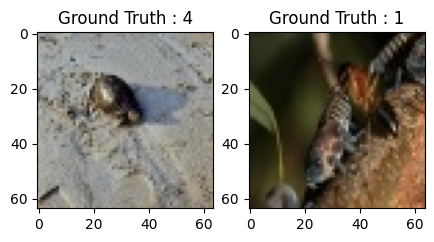

In [77]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

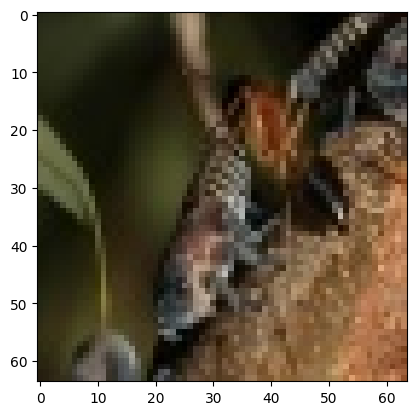

In [78]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [79]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [80]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [81]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(48000, 64, 64, 3) (12000, 64, 64, 3) (48000, 5) (12000, 5)


# Creamos el modelo de CNN

In [82]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

sport_model = Sequential([
    Input(shape=(64, 64, 3)),
    
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.2), # Freno suave (20%)

    # Bloque 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.2), 

    # Bloque 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.3), # Freno medio (30%)

    # Bloque 4 (El más grande)
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.4), # Freno fuerte (40%) antes de aplanar

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5), # Freno máximo (50%) en las neuronas finales
    Dense(nClasses, activation='softmax')
])

# Compilamos con una tasa de aprendizaje (learning rate) un poco más baja para ser precisos
from tensorflow.keras.optimizers import Adam
sport_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

sport_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,533 (5.49 MB)

 Trainable params: 1,438,533 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
sport_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,533 (5.49 MB)

 Trainable params: 1,438,533 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
from tensorflow.keras.optimizers import Adam

# Bajamos la velocidad inicial a 0.0005 para ser más cautelosos al principio
sport_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

print("✅ Modelo compilado con Learning Rate inicial de 0.0005")

✅ Modelo compilado con Learning Rate inicial de 0.0005


# Entrenamos el modelo: Aprende a clasificar imágenes

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Early Stopping: Si no mejora en 8 épocas, para y recupera lo mejor.
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    restore_best_weights=True,
    verbose=1
)

# 2. Reduce Learning Rate: Si se estanca 3 veces, baja la velocidad a la mitad.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       
    patience=3,       
    min_lr=0.00001,   
    verbose=1         
)

print("🚀 Iniciando entrenamiento (Con Data Augmentation + ReduceLR)...")

# 3. Entrenar
sport_train = sport_model.fit(
    datagen.flow(train_X, train_label, batch_size=64),
    epochs=50, 
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[early_stop, reduce_lr] # <--- ¡Ambos activados!
)

print("🏁 Entrenamiento finalizado.")

🚀 Iniciando entrenamiento (Con Data Augmentation + ReduceLR)...
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 109s 142ms/step - accuracy: 0.4084 - loss: 1.3483 - val_accuracy: 0.4598 - val_loss: 1.3222 - learning_rate: 5.0000e-04
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 110s 146ms/step - accuracy: 0.5205 - loss: 1.1472 - val_accuracy: 0.5505 - val_loss: 1.0889 - learning_rate: 5.0000e-04
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 111s 147ms/step - accuracy: 0.5589 - loss: 1.0614 - val_accuracy: 0.5738 - val_loss: 1.0489 - learning_rate: 5.0000e-04
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 87s 116ms/step - accuracy: 0.5842 - loss: 1.0119 - val_accuracy: 0.5663 - val_loss: 1.0549 - learning_rate: 5.0000e-04
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 99s 132ms/step - accuracy: 0.6066 - loss: 0.9665 - val_accuracy: 0.6096 - val_loss: 0.9716 - learning_rate: 5.0000e-04
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.6206 - loss: 0.9365 - val_accuracy: 0.6260 - val_loss: 0.9083 - learn

In [87]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("Modelos/animales5.h5")

# Evaluamos la red

In [88]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7102 - loss: 0.7272


In [89]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7271518111228943
Test accuracy: 0.7102000117301941


In [90]:
sport_train.history

{'accuracy': [0.40837499499320984,
  0.5205416679382324,
  0.5589166879653931,
  0.5841875076293945,
  0.6065833568572998,
  0.6205833554267883,
  0.6315833330154419,
  0.6454583406448364,
  0.6548333168029785,
  0.6654999852180481,
  0.6713958382606506,
  0.6766666769981384,
  0.6838541626930237,
  0.7019791603088379,
  0.706083357334137,
  0.7118124961853027,
  0.7129166722297668,
  0.7169583439826965,
  0.71895831823349,
  0.7200208306312561,
  0.729687511920929,
  0.7337291836738586,
  0.734749972820282,
  0.7396458387374878,
  0.7397500276565552],
 'loss': [1.3483375310897827,
  1.1472231149673462,
  1.0613824129104614,
  1.0119245052337646,
  0.9665083289146423,
  0.9364800453186035,
  0.9062750935554504,
  0.87571120262146,
  0.8567082285881042,
  0.8344876170158386,
  0.8200499415397644,
  0.8079281449317932,
  0.7897515296936035,
  0.7479952573776245,
  0.736395001411438,
  0.7250958681106567,
  0.7233554124832153,
  0.7126273512840271,
  0.705915093421936,
  0.702658295631408

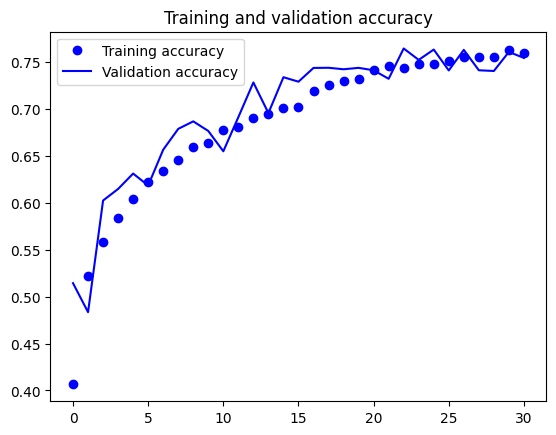

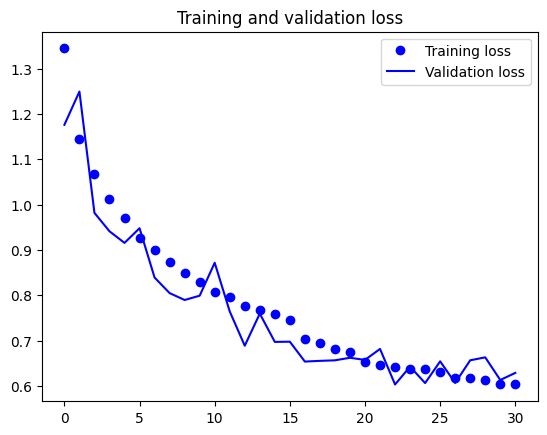

In [24]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [91]:
predicted_classes2 = sport_model.predict(test_X)

469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


In [92]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [93]:
predicted_classes.shape, test_Y.shape

((15000,), (15000,))

# Aprendamos de los errores: Qué mejorar

Found 10653 correct labels


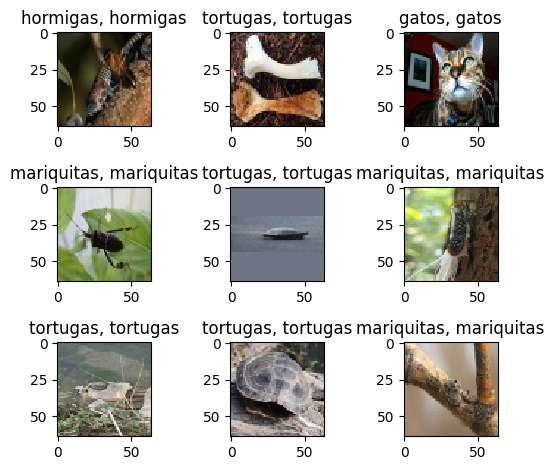

In [94]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)

    # --- AQUÍ ESTÁ EL CAMBIO: (64, 64, 3) ---
    plt.imshow(test_X[correct].reshape(64,64,3), cmap='gray', interpolation='none')

    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 4347 incorrect labels


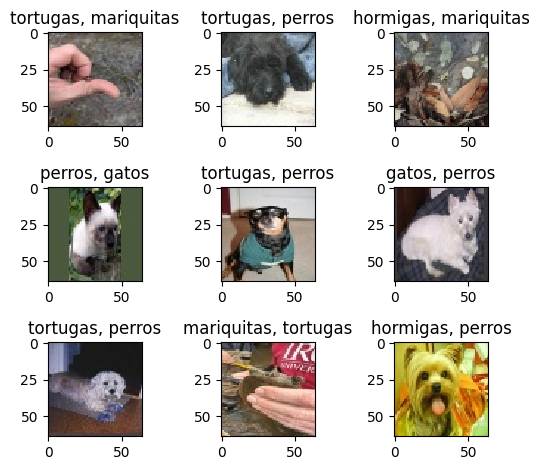

In [95]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))

for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)

    # --- CORRECCIÓN AQUÍ: Cambiar a (64,64,3) ---
    plt.imshow(test_X[incorrect].reshape(64,64,3), cmap='gray', interpolation='none')

    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [66]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.67      0.78      0.72      2720
     Class 1       0.76      0.92      0.83      2849
     Class 2       0.91      0.96      0.93      2775
     Class 3       0.88      0.53      0.66      2906
     Class 4       0.91      0.88      0.90      2775

    accuracy                           0.81     14025
   macro avg       0.82      0.82      0.81     14025
weighted avg       0.83      0.81      0.81     14025



In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import load_model


test_dir = 'tests'
modelo_h5 = 'Modelos/animales3.h5'
sriesgos = ['gatos', 'hormigas', 'mariquitas', 'perros', 'tortugas']
image_extensions = re.compile(r"\.(jpg|jpeg|png|bmp|tiff|WEBP)$", re.IGNORECASE)

try:
    riesgo_model = load_model(modelo_h5)
    print("Modelo cargado exitosamente.")
except Exception as e:
    print(f"ERROR: No se pudo cargar el modelo. {e}")
    exit()

images = []
filenames_found = []

print(f"\nBuscando imágenes en: {test_dir}")
for filename in os.listdir(test_dir):
    # 🌟 CORRECCIÓN CRÍTICA: Solo procesamos archivos de imagen
    if image_extensions.search(filename):
        filepath = os.path.join(test_dir, filename)
        filenames_found.append(filename)
        
        try:
            image = plt.imread(filepath)
            
            if len(image.shape) == 3:
                image_resized = resize(image, (64, 64), anti_aliasing=True, clip=False, preserve_range=True)
                images.append(image_resized)
            
            
        except Exception as e:
            print(f"Error al leer/procesar {filename}. Error: {e}")

if not images:
    print("\nNo se encontraron imágenes válidas o se falló al leer todas.")
else:

    X = np.array(images, dtype=np.uint8) 
    test_X = X.astype('float32')
    test_X = test_X / 255.

    predicted_classes = riesgo_model.predict(test_X) 
    predicted_labels = np.argmax(predicted_classes, axis=1)

    print("\n--- Resultados---")
    for i, label_index in enumerate(predicted_labels):
        print(f"{filenames_found[i]}  {sriesgos[label_index]}")

Modelo cargado exitosamente.

Buscando imágenes en: tests


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

--- Resultados---
gato prueba 1.jpg  gatos
gato prueba 3.jpg  perros
gato prueba 4.jpg  tortugas
gato prueba 5.jpg  tortugas
gato prueba 6.jpg  gatos
gato prueba 7.jpg  gatos
gato.jpg  gatos
gato1.jpg  gatos
horm1.jpg  hormigas
horm2.jpg  hormigas
horm3.jpg  mariquitas
horm4.jpg  hormigas
horm5.jpg  hormigas
hormiga prueba 1.jpg  mariquitas
hormiga prueba 2.jpg  hormigas
hormiga prueba 3.jpg  hormigas
hormiga prueba 4.jpg  hormigas
hormiga prueba 5.jpg  hormigas
hormiga prueba 6.jpg  hormigas
hormiga prueba 7.jpg  mariquitas
hormiga prueba 8.jpg  hormigas
hormiga prueba.jpg  mariquitas
hormiga.jpg  mariquitas
ladybugs02.jpg  hormigas
ladybugs02.webp  mariquitas
ladybugs03.jpg  mariquitas
ladybugs04.jpg  mariquitas
ladybugs05azul.jpg  mariquitas
ladybugsamarilla.jpg  mariquitas
ladybugsamarilla2.jpg  mariquitas
mariquita prueba 1.jpg  mariquitas
mariquita prueba 10.jpg  mariquitas
mariquita prueba 11.jpg  mariquitas
mariquita prueba 13.jpg  mariqui